In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, roc_auc_score, auc
import xgboost as xgb ## install xgboost if not installed

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview

- Question
    - **What features did contribute for customers to be repeaters?**
    - **Can we predict if a customer will be a repeater?**
    - This task is binary classification, using the `repeater` label in `df_train`.
 
- Current situation
    - Repeaters constitute only 3% of the total.
    - The dataset is imbalanced.
    - I plan to use `SMOTE` to address this issue.
 
- Models
    - Logistic linear regression model.
    - Random forest
    - XGBoost

- Possible reasons for customers not becoming repeaters (my hypothesis):
    - Dissatisfaction with the initial purchase experience (late product delivery, issues with the product or packaging based on customer reviews/score)
    - Customer have promotion, so they use olist. Without it, they don't. The question is, why didn't this lead to a second purchase?
    - The time span between the first and second purchase for repeaters
    - Differences in the categories of products purchased (ex: repeaters buy daily necessities, while others buy gadgets?)

## 1. Load data

In [2]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_train.csv')
print(df.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## 2. Prepare df_numeric

In [3]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
df_numeric = df_numeric.drop(columns=['fo_voucher_used']) ## similar to fo_voucher_amount
print(df_numeric.shape)
df_numeric.head()

(92633, 12)


,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
0,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,1
1,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,1
2,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,0
3,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,0
4,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,1


In [4]:
## X should contain information about the first purchase, not RFM stuff.
X = df_numeric.drop(['repeater', 'frequency', 'recency', 'monetary', 'rfm_score'], axis=1)
y = df_numeric['repeater']

## Functions to train model and get results

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
from imblearn.metrics import geometric_mean_score

def train_model_and_get_result(X, y, model, name, is_lf):
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, X.columns)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
        # ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('model', model)
    ])

    ## Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')

    ## Fit the model on the training data
    pipeline.fit(X_train, y_train)

    ## Update the 'model' variable to access feature importance or coefficients
    fitted_model = pipeline.named_steps['model']

    ## Predict on the test data
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

    ## Additional metrics
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    ## Get the Importance of the Features
    feature_names = X.columns
    importances = fitted_model.coef_[0] if is_lf else fitted_model.feature_importances_

    result = {
        'name': name,
        'mean_accuracy': accuracies.mean(),
        'std_accuracy': accuracies.std(),
        'balanced_acc': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'gmean': gmean,
        'kappa': kappa,
        'accuracies': accuracies,
        'roc_curve': {'fpr': fpr_lr.tolist(), 'tpr': tpr_lr.tolist()},
        'feature_importance': {'features': feature_names.tolist(), 'importances': importances.tolist()}
    }

    return result

def print_result(result):
    print("=== Result Summary ===")
    print(f"Mean Accuracy: {result['mean_accuracy']:.4f}")
    print(f"Std Accuracy: {result['std_accuracy']:.4f}")
    print(f"Balanced Accuracy: {result['balanced_acc']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")
    print(f"AUC: {result['auc']:.4f}")
    print(f"G-Mean: {result['gmean']:.4f}")
    print(f"Cohen's Kappa: {result['kappa']:.4f}")

    print("\nDetailed Accuracies per Fold:")
    for idx, acc in enumerate(result['accuracies'], start=1):
        print(f" Fold {idx}: {acc:.4f}")

    print("\n=== Feature Importance ===")
    feature_importances = pd.DataFrame({
        'Feature': result['feature_importance']['features'],
        'Importance': result['feature_importance']['importances']
    })
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    print(feature_importances.to_string(index=False))

## Logistic Regression

In [6]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
result_lr = train_model_and_get_result(X, y, model_lr, "LogisticRegression", is_lf=True)

print_result(result_lr)

=== Result Summary ===
Mean Accuracy: 0.9691
Std Accuracy: 0.0001
Balanced Accuracy: 0.5008
Precision: 0.3333
Recall: 0.0017
F1 Score: 0.0034
AUC: 0.5354
G-Mean: 0.0416
Cohen's Kappa: 0.0031

Detailed Accuracies per Fold:
 Fold 1: 0.9690
 Fold 2: 0.9690
 Fold 3: 0.9690
 Fold 4: 0.9692
 Fold 5: 0.9693

=== Feature Importance ===
                 Feature  Importance
   customer_in_sao_paulo    0.035136
fo_voucher_payment_value    0.021396
           fo_is_weekday    0.001895
    fo_review_score_mean   -0.001980
           fo_is_daytime   -0.063746
  fo_delivery_delay_days   -0.108782
        fo_payment_value   -0.116038


**Interpretation of Result Summary**
- **Mean CV Accuracy**: The average accuracy across the five folds is approximately 66.23%, indicating that, on average, the model correctly predicts whether a customer will be a repeater about two-thirds of the time.
- **Variability**: The standard deviation of the CV accuracy scores is about 6.21%, showing a moderate variation in the model's performance across different folds. This variation can be attributed to the diversity of data in each fold or intrinsic differences in the difficulty of predicting certain subsets of the data.
- **Range of Accuracy Scores**: The accuracy scores across folds range from approximately 56.73% to 74.10%, highlighting the inconsistent performance of the model across different segments of the dataset.

**Interpretation of Feature Importance**
- `fo_voucher_used`
  - The most influential positive feature, suggesting that customers who used a voucher in their first order are more likely to repeat.
- `fo_is_weekday`
  - Customers who make their first order on a weekday are less likely to repeat, with a significant negative influence.
- `fo_is_daytime`
  - Similar to fo_is_weekday, orders made during daytime have a notably negative effect on repeat probability.
- `customer_in_sao_paulo`
  - Shows no effect

**Next Steps**
- Although binary classification is used in `fo_is_weekday` and `fo_is_daytime`, more detailed classification by time or day of the week could improve the performance of the model.
- We can also drop `customer_in_sao_paulo` as it has no effect on the repeater probability.
- Add intersection terms

## Random Forest

In [7]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
result_rf = train_model_and_get_result(X, y, model_rf, "RandomForest", is_lf=False)

print_result(result_rf)

=== Result Summary ===
Mean Accuracy: 0.6082
Std Accuracy: 0.0123
Balanced Accuracy: 0.5260
Precision: 0.0352
Recall: 0.4464
F1 Score: 0.0652
AUC: 0.5272
G-Mean: 0.5200
Cohen's Kappa: 0.0078

Detailed Accuracies per Fold:
 Fold 1: 0.6247
 Fold 2: 0.6056
 Fold 3: 0.5900
 Fold 4: 0.6185
 Fold 5: 0.6021

=== Feature Importance ===
                 Feature  Importance
  fo_delivery_delay_days    0.451631
        fo_payment_value    0.208099
    fo_review_score_mean    0.195513
fo_voucher_payment_value    0.053104
   customer_in_sao_paulo    0.035493
           fo_is_weekday    0.032106
           fo_is_daytime    0.024053


**Interpretation of Result Summary**
- The mean accuracy is higher than Logistic Regression, at approximately 66.23%.
  - Main reason is Random Forest is a non-linear model. We have some binary features, so the performance can be better than Logistic Regression. 

**Interpretation of Feature Importance**
- There are no significant feature that impact the model performance.
- Again, customer_in_sao_paulo has no effect.

**Next Steps**
- Drop `customer_in_sao_paulo` and `fo_voucher_used`.

## XGBoost

In [8]:
model_xgb = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(len(y[y == 0]) / len(y[y == 1])),
    max_depth=4,
    min_child_weight=1,
    learning_rate=0.01,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


result_xgb = train_model_and_get_result(X, y, model_xgb, "XGBoost", is_lf=False)

print_result(result_xgb)

=== Result Summary ===
Mean Accuracy: 0.0311
Std Accuracy: 0.0003
Balanced Accuracy: 0.5001
Precision: 0.0312
Recall: 1.0000
F1 Score: 0.0605
AUC: 0.5373
G-Mean: 0.0149
Cohen's Kappa: 0.0000

Detailed Accuracies per Fold:
 Fold 1: 0.0310
 Fold 2: 0.0316
 Fold 3: 0.0310
 Fold 4: 0.0308
 Fold 5: 0.0312

=== Feature Importance ===
                 Feature  Importance
  fo_delivery_delay_days    0.270951
    fo_review_score_mean    0.177527
           fo_is_weekday    0.138805
        fo_payment_value    0.133153
   customer_in_sao_paulo    0.098076
fo_voucher_payment_value    0.095199
           fo_is_daytime    0.086289


**Interpretation of Result Summary**
- the accuracy is better than Random Forest. 

**Interpretation of Feature Importance**
- `fo_review_score_mean` is the most important feature.
- Same as Random Forest, `customer_in_sao_paulo` and `fo_voucher_used` has no effect.

## Compare the 3 models

In [9]:
results = [result_lr, result_rf, result_xgb]

def compare_results(results):
    comparison_df = pd.DataFrame({
        'Model': [result['name'] for result in results],
        # 'Mean Accuracy': [result['mean_accuracy'] for result in results],
        # 'Std Accuracy': [result['std_accuracy'] for result in results],
        'Balaced Accuracy': [result['balanced_acc'] for result in results],
        # 'Precision': [result['precision'] for result in results],
        # 'Recall': [result['recall'] for result in results],
        'F1 Score': [result['f1_score'] for result in results],
        'AUC': [result['auc'] for result in results],
        'G-Mean': [result['gmean'] for result in results],
        "Cohen's Kappa": [result['kappa'] for result in results]
    })

    print("=== Model Comparison ===")
    print(comparison_df.to_string(index=False))

compare_results(results)

=== Model Comparison ===
             Model  Balaced Accuracy  F1 Score      AUC   G-Mean  Cohen's Kappa
LogisticRegression          0.500809  0.003442 0.535407 0.041592       0.003121
      RandomForest          0.526041  0.065209 0.527165 0.519973       0.007824
           XGBoost          0.500111  0.060520 0.537264 0.014928       0.000014


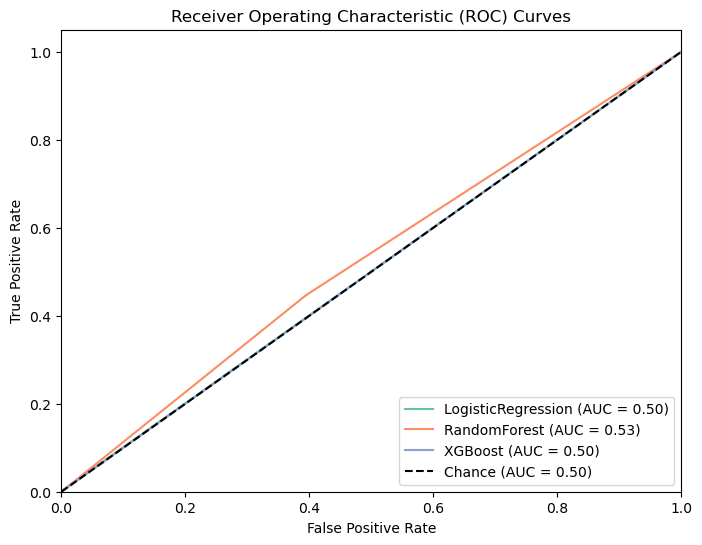

In [10]:
def plot_roc_curves(results):
    plt.figure(figsize=(8, 6))

    for result in results:
        name = result['name']
        fpr = result['roc_curve']['fpr']
        tpr = result['roc_curve']['tpr']
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curves(results)

#AUC is too low because the sample data is imbalanced. so it's ok.
#We can use other metrics like precision, recall, f1 score to evaluate the model.

In [11]:
def plot_mean_accuracy(results):
    names = [result['name'] for result in results]
    mean_accuracies = [result['mean_accuracy'] for result in results]

    plt.bar(names, mean_accuracies)
    plt.xlabel('Model')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy Comparison')
    plt.show()


def plot_test_accuracy(results):
    names = [result['name'] for result in results]
    mean_accuracies = [result['test_accuracy'] for result in results]

    plt.bar(names, mean_accuracies)
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy Comparison')
    plt.show()


def combine_feature_importances(results):
    feature_names = results[0]['feature_importance']['features']
    combined = pd.DataFrame({'Feature': feature_names})

    for result in results:
        combined[result['name']] = result['feature_importance']['importances']

    return combined


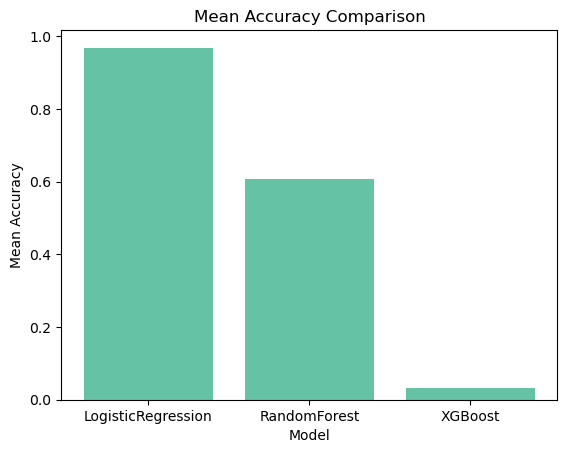

KeyError: 'test_accuracy'

In [12]:
plot_mean_accuracy(results)
plot_test_accuracy(results)

combined_importances = combine_feature_importances(results)
combined_importances

## Compare the features

We failed to crete a good model to predict the repeater. so we compare the features to see if we can find any insights.

In [ ]:
df_numeric_nr = df_numeric[df_numeric['repeater'] == 0].drop(columns=['repeater', 'frequency', 'recency', 'monetary', 'rfm_score'])
df_numeric_r = df_numeric[df_numeric['repeater'] == 1].drop(columns=['repeater', 'frequency', 'recency', 'monetary', 'rfm_score'])

print(f"df_numeric_nr: {df_numeric_nr.shape}")
print(f"df_numeric_r: {df_numeric_r.shape}")

df_numeric_nr: (89782, 7)
df_numeric_r: (2851, 7)


In [ ]:
# compare describe() of df_numeric_nr and df_numeric_r

print("non-repeater: ")
df_numeric_nr.describe().T

non-repeater: 


,count,mean,std,min,25%,50%,75%,max
fo_payment_value,89782.0,160.419588,219.794012,9.59,62.01,105.38,176.5575,13664.08
fo_is_daytime,89782.0,0.906507,0.291124,0.00,1.00,1.00,1.0000,1.00
fo_is_weekday,89782.0,0.770299,0.420643,0.00,1.00,1.00,1.0000,1.00
fo_delivery_delay_days,89782.0,-11.862433,10.135341,-147.00,-17.00,-12.00,-7.0000,188.00
fo_review_score_mean,89782.0,4.153138,1.285019,1.00,4.00,5.00,5.0000,5.00
fo_voucher_payment_value,89782.0,3.466973,28.327126,0.00,0.00,0.00,0.0000,1839.05
customer_in_sao_paulo,89782.0,0.419171,0.493426,0.00,0.00,0.00,1.0000,1.00


In [ ]:
print("repeater: ")
df_numeric_r.describe().T

repeater: 


,count,mean,std,min,25%,50%,75%,max
fo_payment_value,2851.0,146.446086,192.751790,11.62,59.785,101.14,171.68,4950.34
fo_is_daytime,2851.0,0.883199,0.321239,0.00,1.000,1.00,1.00,1.00
fo_is_weekday,2851.0,0.769555,0.421192,0.00,1.000,1.00,1.00,1.00
fo_delivery_delay_days,2851.0,-12.790600,9.546635,-78.00,-17.000,-13.00,-8.00,47.00
fo_review_score_mean,2851.0,4.179586,1.276996,1.00,4.000,5.00,5.00,5.00
fo_voucher_payment_value,2851.0,3.858843,28.884369,0.00,0.000,0.00,0.00,871.44
customer_in_sao_paulo,2851.0,0.434234,0.495743,0.00,0.000,0.00,1.00,1.00


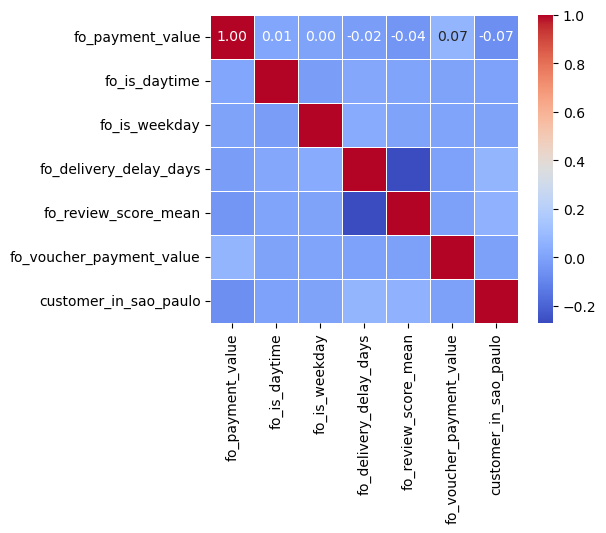

In [ ]:
corr_nr = df_numeric_nr.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_nr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

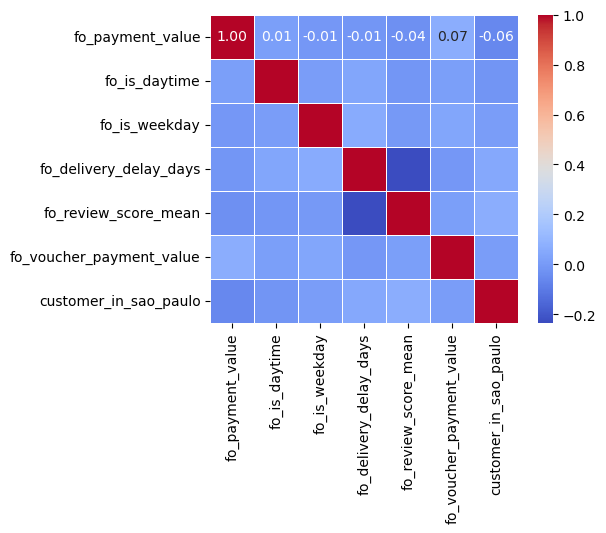

In [ ]:
corr_r = df_numeric_r.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_r, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()